In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN,self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2,64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,1)
        )
    def forward(self,x):
        return self.net(x)

In [3]:
def intial_condition(x):
    return torch.sin(torch.pi * x) 
def boundary_condition(x,t, custom_value):
    return torch.full_like(x, custom_value)

In [4]:
def generate_training_data(num_points):
    x = torch.rand(num_points, 1, requires_grad = True)
    t = torch.rand(num_points, 1, requires_grad = True)
    
    return x,t

In [5]:
def generate_boundary_training_data(num_points):
    # create x_boundary and t_boundary
    x_boundary_0 = torch.zeros(num_points//2, 1, requires_grad=True)  # x=0 boundary
    x_boundary_1 = torch.ones(num_points//2, 1, requires_grad=True)   # x=1 boundary
    x_boundary = torch.cat([x_boundary_0, x_boundary_1], dim=0)       # combine both boundaries
    t_boundary = torch.rand(num_points, 1, requires_grad=True)   # random time points
    
    return x_boundary, t_boundary

In [6]:
def pde(x,t,model):
    input_data = torch.cat([x,t],dim=1)
    u = model(input_data)
    alpha= 0.1

    u_x = torch.autograd.grad(u, x,grad_outputs= torch.ones_like(u), create_graph= True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x,x,grad_outputs= torch.ones_like(u_x), create_graph= True, retain_graph=True)[0]
    u_t = torch.autograd.grad(u,t,grad_outputs= torch.ones_like(u), create_graph= True, retain_graph=True)[0]
    heat_eq_residual = alpha * u_xx - u_t
    return heat_eq_residual

In [7]:
def train_PINN(model, num_iterations, num_points):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    for  iteration in range(num_iterations):
        optimizer.zero_grad()
        
        x,t = generate_training_data(num_points)
        
        x_b,t_b = generate_boundary_training_data(num_points)
        
        t_intial = torch.zeros_like(t)
        u_intial = intial_condition(x)
        
        custom_value = 0
        u_boundary_x = boundary_condition(x_b,t_b,custom_value)
        
        residual = pde(x,t,model)
        
        loss =  nn.MSELoss()(u_intial, model(torch.cat([x,t_intial], dim=1))) + \
                nn.MSELoss()(u_boundary_x, model(torch.cat([x_b,t_b], dim=1))) + \
                nn.MSELoss()(residual, torch.zeros_like(residual))
                
        loss.backward()
        optimizer.step()
        
        if iteration % 100 ==0:
            print("itration",iteration, "loss",loss )

In [8]:
model = PINN()
num_iterations = 5000
num_points = 1000
train_PINN(model,num_iterations,num_points)

itration 0 loss tensor(0.3914, grad_fn=<AddBackward0>)
itration 100 loss tensor(0.1733, grad_fn=<AddBackward0>)
itration 200 loss tensor(0.0092, grad_fn=<AddBackward0>)
itration 300 loss tensor(0.0020, grad_fn=<AddBackward0>)
itration 400 loss tensor(0.0007, grad_fn=<AddBackward0>)
itration 500 loss tensor(0.0003, grad_fn=<AddBackward0>)
itration 600 loss tensor(0.0002, grad_fn=<AddBackward0>)
itration 700 loss tensor(0.0001, grad_fn=<AddBackward0>)
itration 800 loss tensor(0.0001, grad_fn=<AddBackward0>)
itration 900 loss tensor(6.9597e-05, grad_fn=<AddBackward0>)
itration 1000 loss tensor(7.3687e-05, grad_fn=<AddBackward0>)
itration 1100 loss tensor(5.5667e-05, grad_fn=<AddBackward0>)
itration 1200 loss tensor(3.7768e-05, grad_fn=<AddBackward0>)
itration 1300 loss tensor(3.7034e-05, grad_fn=<AddBackward0>)
itration 1400 loss tensor(3.5449e-05, grad_fn=<AddBackward0>)
itration 1500 loss tensor(3.3765e-05, grad_fn=<AddBackward0>)
itration 1600 loss tensor(3.1951e-05, grad_fn=<AddBackwa

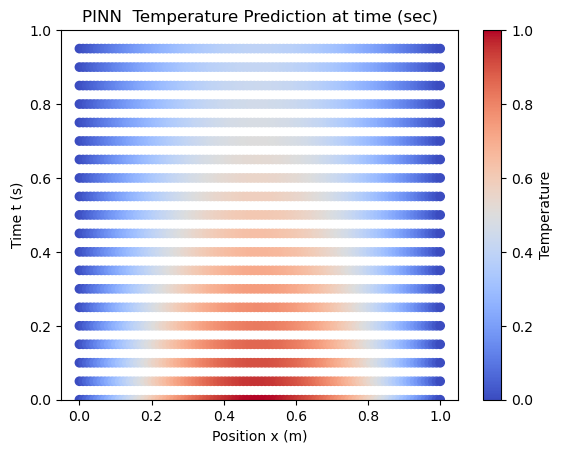

In [9]:
num_time_steps= 20

x_plot = []
t_plot = []
u_pred = []
with torch.no_grad():
    x_vals = torch.linspace(0,1,100)
    # for t in range 0-1 devided to 20 steps
    for t in range(num_time_steps):
        t_val = torch.ones_like(x_vals) * t/num_time_steps # spacify the time step between 0 and 1
        input_data = torch.stack([x_vals.flatten(),t_val.flatten()], dim=1)
        solution = model(input_data)
        # store x t and solution
        x_plot.append(x_vals)
        t_plot.append(t_val)
        u_pred.append(solution)

plt.scatter(x_plot, t_plot, c=u_pred, cmap='coolwarm')
plt.clim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Position x (m)')
plt.ylabel('Time t (s)')
plt.title(f'PINN  Temperature Prediction at time (sec)')
plt.colorbar(label='Temperature')
plt.show()

    
    